## Build the dataset

In [1]:
import os
import torch
from convokit import Corpus, download

filename = "~/.convokit/downloads/friends-corpus"
corpus = Corpus(filename=os.path.expanduser(filename))

utterance = corpus.get_utterance('s07_e14_c01_u018')
print(utterance.speaker.id)
print(utterance.text)

Rachel Green
Well, can I keep the presents and still be 29?


In [2]:
import re
re_pattern = "[^0-9a-zA-Z,.?!' ]"

all_utterance = []

for utterance in corpus.iter_utterances():
    speaker = utterance.speaker.id
    if speaker == "TRANSCRIPT_NOTE":
        # Only interested in conversations
        continue
    speaker = re.sub(re_pattern, '', speaker)
    text = re.sub(re_pattern, '', utterance.text)
    all_utterance.append(f"{speaker}\n{text}")

n = int(len(all_utterance) * 0.9)
train_data_text = '\n\n'.join(all_utterance[:n])
val_data_text = '\n\n'.join(all_utterance[n:])

print(train_data_text[:500])

Monica Geller
There's nothing to tell! He's just some guy I work with!

Joey Tribbiani
C'mon, you're going out with the guy! There's gotta be something wrong with him!

Chandler Bing
All right Joey, be nice. So does he have a hump? A hump and a hairpiece?

Phoebe Buffay
Wait, does he eat chalk?

Phoebe Buffay
Just, 'cause, I don't want her to go through what I went through with Carl oh!

Monica Geller
Okay, everybody relax. This is not even a date. It's just two people going out to dinner and no


In [3]:
all_characters = sorted(list(set(train_data_text)))
stoi = {s:i for i, s in enumerate(sorted(all_characters))}
itos = {i:s for s, i in stoi.items()}

print("Dictionary size:", len(stoi))
print(stoi)

Dictionary size: 69
{'\n': 0, ' ': 1, '!': 2, "'": 3, ',': 4, '.': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '?': 16, 'A': 17, 'B': 18, 'C': 19, 'D': 20, 'E': 21, 'F': 22, 'G': 23, 'H': 24, 'I': 25, 'J': 26, 'K': 27, 'L': 28, 'M': 29, 'N': 30, 'O': 31, 'P': 32, 'Q': 33, 'R': 34, 'S': 35, 'T': 36, 'U': 37, 'V': 38, 'W': 39, 'X': 40, 'Y': 41, 'Z': 42, 'a': 43, 'b': 44, 'c': 45, 'd': 46, 'e': 47, 'f': 48, 'g': 49, 'h': 50, 'i': 51, 'j': 52, 'k': 53, 'l': 54, 'm': 55, 'n': 56, 'o': 57, 'p': 58, 'q': 59, 'r': 60, 's': 61, 't': 62, 'u': 63, 'v': 64, 'w': 65, 'x': 66, 'y': 67, 'z': 68}


In [4]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda c: ''.join([itos[v.item()] for v in c])

train_data = encode(train_data_text)
val_data = encode(val_data_text)

print(encode("Hello world"))
print(decode(encode("Hello world")))

tensor([24, 47, 54, 54, 57,  1, 65, 57, 60, 54, 46])
Hello world


In [5]:
torch.manual_seed(100)
batch_size = 4
block_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split):
    if split == 'train':
        data = train_data
    elif split == 'val':
        data = val_data

    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return (x, y)

x, y = get_batch('train')
print(x[0], '->', y[0])
print()
for t in range(block_size):
    print(f"{x[0, :t+1]} -> {y[0, t]}")
    print(f"{decode(x[0, :t+1])} -> {decode(y[0, t].view(-1))}")

tensor([52, 43, 45, 53, 47, 62,  5,  0]) -> tensor([43, 45, 53, 47, 62,  5,  0,  0])

tensor([52]) -> 43
j -> a
tensor([52, 43]) -> 45
ja -> c
tensor([52, 43, 45]) -> 53
jac -> k
tensor([52, 43, 45, 53]) -> 47
jack -> e
tensor([52, 43, 45, 53, 47]) -> 62
jacke -> t
tensor([52, 43, 45, 53, 47, 62]) -> 5
jacket -> .
tensor([52, 43, 45, 53, 47, 62,  5]) -> 0
jacket. -> 

tensor([52, 43, 45, 53, 47, 62,  5,  0]) -> 0
jacket.
 -> 



# A simple MLP

In [60]:
from torch import nn
from torch.nn import functional as F

class FeedForward(nn.Module):
    def __init__(self, d_emb, d_ff, dropout):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_emb, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_emb),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff(x)

In [61]:
d_vocab = len(stoi)
d_emb = 64
d_ff = 128
dropout = 0.1


# v0.1
class SimpleLanguageModel(nn.Module):
    '''Simple Bigram language model with a single feedforward layer'''
    def __init__(self, d_vocab, d_emb, d_ff, dropout):
        super().__init__()
        self.emb = nn.Embedding(d_vocab, d_emb)  # B, T -> B, T, d_emb
        self.ffwd = FeedForward(d_emb, d_ff, dropout)  # B, T, d_emb -> B, T, d_emb
        self.lm_head = nn.Linear(d_emb, d_vocab)  # B, T, d_emb -> B, T, d_vocab

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        # B, T = x.shape
        x = self.emb(x) # B, T, d_emb
        logits = self.lm_head(x) # B, T, d_vocab

        loss = None
        if targets is not None:
            B, T, d_vocab = logits.shape
            logits = logits.view(-1, d_vocab)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, x, n_tokens):
        # B, T = x.shape
        for _ in range(n_tokens):
            x_cond = x[:, -block_size:]
            logits, loss = self(x_cond)  # logits: B, T, d_vocab
            logits = logits[:, -1, :]  # B, d_vocab
            probs = F.softmax(logits, dim=-1)  # B, d_vocab
            x_next = torch.multinomial(probs, num_samples=1)  # B, 1
            x = torch.cat((x, x_next), dim=1)  # B, T+1
        return x

In [62]:
model = SimpleLanguageModel(d_vocab, d_emb, d_ff, dropout).to(device)

In [63]:
xb, yb = get_batch('train')
xb, yb = xb[:1], yb[:1]
logit, loss = model(xb, yb)
print(logit.shape)
print(loss)

torch.Size([8, 69])
tensor(4.2338, grad_fn=<NllLossBackward0>)


In [64]:
# v0.2 - with the generate function
class SimpleLanguageModel(nn.Module):
    '''Simple Bigram language model with a single feedforward layer'''
    def __init__(self, d_vocab, d_emb, d_ff, dropout):
        super().__init__()
        self.emb = nn.Embedding(d_vocab, d_emb)  # B, T -> B, T, d_emb
        self.ffwd = FeedForward(d_emb, d_ff, dropout)  # B, T, d_emb -> B, T, d_emb
        self.lm_head = nn.Linear(d_emb, d_vocab)  # B, T, d_emb -> B, T, d_vocab

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        # B, T = x.shape
        x = self.emb(x) # B, T, d_emb
        logits = self.lm_head(x) # B, T, d_vocab

        loss = None
        if targets is not None:
            B, T, d_vocab = logits.shape
            logits = logits.view(-1, d_vocab)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, x, n_tokens):
        # B, T = x.shape
        for _ in range(n_tokens):
            x_cond = x[:, -block_size:]
            logits, loss = self(x_cond)  # logits: B, T, d_vocab
            logits = logits[:, -1, :]  # B, d_vocab
            probs = F.softmax(logits, dim=-1)  # B, d_vocab
            x_next = torch.multinomial(probs, num_samples=1)  # B, 1
            x = torch.cat((x, x_next), dim=1)  # B, T+1
        return x

In [11]:
model = SimpleLanguageModel(d_vocab, d_emb, d_ff, dropout).to(device)
gen_text = model.generate(x=torch.zeros((1, 1), dtype=torch.long), n_tokens=100)
print(gen_text)
print(decode(gen_text[0]))

tensor([[ 0, 62,  4, 66, 56, 65, 20, 29, 16, 43, 28,  0,  8, 50,  3, 55, 13, 65,
         55,  7, 15, 61,  0, 47, 43, 52, 28, 15, 64, 57,  2, 14, 14,  6, 24, 61,
         55, 56, 28,  3, 35, 31, 30, 21, 16, 56, 18, 49, 59, 38,  1,  7, 38, 16,
         61,  5, 32, 25, 49,  6, 44, 27, 47, 35, 30, 59, 35,  4, 24,  9, 57, 64,
         43, 66, 51, 10,  0, 28, 62, 24, 44, 65, 40, 37, 14, 67, 51, 63, 57, 56,
         10, 65, 28, 42, 28, 54, 38, 65, 43, 24, 33]])

t,xnwDM?aL
2h'm7wm19s
eajL9vo!880HsmnL'SONE?nBgqV 1V?s.PIg0bKeSNqS,H3ovaxi4
LtHbwXU8yiuon4wLZLlVwaHQ


# Training & Evaluation

In [12]:
@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    model.eval()
    total_loss = 0.
    for i in range(eval_iters):
        x, y = get_batch('val')
        logits, loss = model(x, y)
        total_loss += loss.item()
    return total_loss / eval_iters

estimate_loss(model)

4.234402709007263

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [14]:
batch_size = 32
for steps in range(100000):
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 5000 == 0:
        print(steps, loss.item())
        if steps % 20000 == 0:
            print("Validation loss:", estimate_loss(model))

    # comment out after confirmed it works
    # if steps >= 5000:
    #     break

0 4.234487533569336
Validation loss: 4.23272953748703
5000 2.5389506816864014
10000 2.267601728439331
15000 2.421492338180542
20000 2.291759490966797
Validation loss: 2.3960675978660584
25000 2.4318416118621826
30000 2.4329137802124023
35000 2.277162790298462
40000 2.3940908908843994
Validation loss: 2.405582616329193
45000 2.512033462524414
50000 2.228994607925415
55000 2.5251286029815674
60000 2.400392770767212
Validation loss: 2.4019481694698332
65000 2.4505093097686768
70000 2.365840435028076
75000 2.348484754562378
80000 2.289278268814087
Validation loss: 2.40008819937706
85000 2.407731056213379
90000 2.297285318374634
95000 2.272923469543457


In [19]:
# Generation
print(decode(
    model.generate(x=torch.zeros((1, 1), dtype=torch.long), n_tokens=100)[0]
))


Yotoey i
Molkindoey, ss!
Doni
Weroe ks t benott'thig I't.


Jous jut w, arseeel angh hate. Tars s te


## Self attention

Self attention is a communication mechanism.

In [20]:
torch.manual_seed(415)
values = torch.randint(0, 10, (3, 2)).float()

# Version 1: naive for-loop
first_k_avg = torch.empty_like(values)
for i in range(first_k_avg.shape[0]):
    for j in range(first_k_avg.shape[1]):
        first_k_avg[i, j] = values[:i + 1, j].mean()

print("values = \n", values)
print('-' * 10)
print("first_k_avg = \n", first_k_avg)

values = 
 tensor([[5., 8.],
        [0., 5.],
        [3., 4.]])
----------
first_k_avg = 
 tensor([[5.0000, 8.0000],
        [2.5000, 6.5000],
        [2.6667, 5.6667]])


In [21]:
# Version 2: mat mul
num_rows = values.shape[0]
wei = torch.tril(torch.ones(num_rows, num_rows))
wei = wei / torch.sum(wei, 1, keepdim=True)
print("wei = \n", wei)
print('-' * 10)
print("first_k_avg = \n", wei @ values)

wei = 
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
----------
first_k_avg = 
 tensor([[5.0000, 8.0000],
        [2.5000, 6.5000],
        [2.6667, 5.6667]])


In [22]:
# Version 3: softmax
wei = torch.zeros((num_rows, num_rows))
tril = torch.tril(torch.ones_like(wei))
wei = wei.masked_fill(tril == 0, float('-inf'))
print("wei before softmax:\n", wei)
print('-' * 10)
wei = F.softmax(wei, dim=1)
print("wei after softmax:\n", wei)
print('-' * 10)
print("first_k_avg = \n", wei @ values)

wei before softmax:
 tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
----------
wei after softmax:
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
----------
first_k_avg = 
 tensor([[5.0000, 8.0000],
        [2.5000, 6.5000],
        [2.6667, 5.6667]])


In [23]:
# Version 4: serlf attention

B, T, C = 4, 4, 32  # batch, time, channels (embeddings)
x = torch.randn(B, T, C)

# Single head self attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)  # (B, T, 16)
q = query(x)  # (B, T, 16)
wei = q @ k.transpose(-2, -1) * C**-0.5  # (B, T, 16) @ (B, 16, T) -> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

print("wei:\n", wei)
print('-' * 10)
print("weight vector for third prediction:\n", wei[0, 2])
print("out shape:", out.shape)

wei:
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4607, 0.5393, 0.0000, 0.0000],
         [0.3991, 0.2089, 0.3920, 0.0000],
         [0.2587, 0.2108, 0.2907, 0.2397]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4038, 0.5962, 0.0000, 0.0000],
         [0.2823, 0.3892, 0.3285, 0.0000],
         [0.2289, 0.2493, 0.2322, 0.2896]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3789, 0.6211, 0.0000, 0.0000],
         [0.3268, 0.3199, 0.3533, 0.0000],
         [0.1970, 0.2184, 0.2262, 0.3584]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4430, 0.5570, 0.0000, 0.0000],
         [0.2956, 0.3503, 0.3541, 0.0000],
         [0.2012, 0.2451, 0.2963, 0.2574]]], grad_fn=<SoftmaxBackward0>)
----------
weight vector for third prediction:
 tensor([0.3991, 0.2089, 0.3920, 0.0000], grad_fn=<SelectBackward0>)
out shape: torch.Size([4, 4, 16])


## Notes on Key, Query, Value in self attention

Attention is a communication mechanism. It works as a directed graph, passing information along some direction. In text generation, it often involves passing information from past tokens to future tokens.

There are three components in self attention mechanism.
* Query - Q(x) projects what information x is seeking
* Key - K(x) projects what information x contains
* Value - V(x) determines what information should be aggregated for the purpose of this single attention head

To understand Q, K, V intuitively,
* Think of x like private information or private key of a token, it is then projected into the Query, Key, and Value handled by the attention head.
* The output of self attention is a weighted sum of the projection V(x), not the tokens themselves. Why?
    * It enables us to simultaneously consider various aspects of tokens in different heads after we introduce multi-head attention mechanism next.
    * For example, in processing the word "cat" within a sentence, different attention heads might aggregate information with regards to its grammatical role (noun), its conceptual meaning as an animal, or its syntactic function as a subject or object. This diversity allows for a richer, more nuanced understanding of text.


In [68]:
class Head(nn.Module):
    '''Single head self attention'''

    def __init__(self, d_emb, d_head):
        super().__init__()
        self.d_head = d_head
        self.key = nn.Linear(d_emb, d_head, bias=False)
        self.query = nn.Linear(d_emb, d_head, bias=False)
        self.value = nn.Linear(d_emb, d_head, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # x: B, T, d_emb
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2, -1) * (self.d_head ** -0.5)
        wei = wei.masked_fill(self.tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        out = wei @ v
        return out


class MultiHead(nn.Module):
    '''Multi head self attention'''

    def __init__(self, num_heads, d_emb, d_head):
        super().__init__()
        self.heads = nn.ModuleList([Head(d_emb, d_head) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * d_head, d_emb)

    def forward(self, x):
        # x: B, T, d_emb
        head_out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(head_out)
        return out

## Final Notes on Attention Mechanism

1. **Position Encoding**: Attention mechanisms inherently lack a notion of order, unlike convolutions. Therefore, inputs to the attention mechanism should include positional information to maintain sequence context.
2. **Scaled Attention**: To prevent the softmax function from collapsing into a one-hot vector, it's crucial that the weights (Q @ K) are diffused appropriately, hence the need for scaling attention (divided by d_head**0.5).
3. **Batch Isolation**: Examples within the same batch do not interact; each instance is processed independently.
4. **Transformer Architecture Variations**:
    - **Decoder Block**: Restricts information flow to prevent future tokens from influencing the output, typically used in output generation phases.
    - **Encoder Block**: Allows free communication among all nodes, fully utilizing context, typically used in input interpretation phases.
    - **Application in the Transformer paper**: In context of machine translation, the original paper uses Encoder Blocks for source language text, encoding full contextual understanding, and uses Decoder Blocks for target language text, ensuring generated content is influenced only by preceding text and the source content.

In addition to self-attention, a transformer block comprises:

- **Computation Layer**: a feedforward network computes over the aggregated information, but on per token basis (no communication between two tokens at this step)
- **Optimization Techniques for Deep Networks**:
    - **Residual Connection**: Facilitates learning by creating shortcuts for gradients, acting as a "super-highway" for backpropagation.
    - **Layer Normalization**: Standardizes the inputs to each layer, ensuring consistent scale and aiding in stable training.
    - **Dropout**: Randomly omits a subset of features at each layer to prevent overfitting and encourage generalized representations.

## Attention Block

In [69]:
class LayerNorm1d:
    '''Layer normalization over the last dimension'''

    def __init__(self, dim, eps=1e-5):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # In batch norm, we aggregate over columns
        # In layer norm, we aggregate over rows
        xmean = x.mean(1, keepdim=True)
        xvar = x.var(1, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [70]:
class TransformerBlock(nn.Module):
    '''Transformer block with multi-head attention and feedforward'''

    def __init__(self, n_emb, n_head):
        super().__init__()
        d_head = n_emb // n_head
        self.attn = MultiHead(n_head, n_emb, d_head)
        self.ffwd = FeedForward(n_emb, n_emb, dropout=0.1)
        self.ln1 = LayerNorm1d(n_emb)
        self.ln2 = LayerNorm1d(n_emb)

    def forward(self, x):
        # x: B, T, n_emb
        # with residual connection
        x = x + self.attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [71]:
# v0.3 - with the transformer block
class SimpleLanguageModelWithTransformer(nn.Module):
    '''Simple Bigram language model with transformer layers'''
    def __init__(self, d_vocab, d_emb, num_heads, n_layers):
        super().__init__()
        self.token_emb = nn.Embedding(d_vocab, d_emb)  # B, T -> B, T, d_emb
        self.position_emb = nn.Embedding(block_size, d_emb)  # B, T -> B, T, d_emb
        # Note: Changed here
        # self.ffwd = FeedForward(d_emb, d_ff, dropout)  # B, T, d_emb -> B, T, d_emb
        self.blocks = nn.Sequential(
            *[TransformerBlock(d_emb, num_heads) for _ in range(n_layers)]
        )
        self.ln_final = LayerNorm1d(d_emb)
        self.lm_head = nn.Linear(d_emb, d_vocab)  # B, T, d_emb -> B, T, d_vocab

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        _, T = x.shape
        token_emb = self.token_emb(x) # B, T, d_emb
        pos_emb = self.position_emb(torch.arange(T, device=device))
        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_final(x)
        logits = self.lm_head(x) # B, T, d_vocab

        loss = None
        if targets is not None:
            B, T, d_vocab = logits.shape
            logits = logits.view(-1, d_vocab)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, x, n_tokens):
        # B, T = x.shape
        for _ in range(n_tokens):
            x_cond = x[:, -block_size:]
            logits, loss = self(x_cond)  # logits: B, T, d_vocab
            logits = logits[:, -1, :]  # B, d_vocab
            probs = F.softmax(logits, dim=-1)  # B, d_vocab
            x_next = torch.multinomial(probs, num_samples=1)  # B, 1
            x = torch.cat((x, x_next), dim=1)  # B, T+1
        return x

In [72]:
n_layer = 2
num_heads = 4
model = SimpleLanguageModelWithTransformer(d_vocab, d_emb, num_heads, n_layer)
model = model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

58949


In [79]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32
for steps in range(100000):
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 5000 == 0:
        print(steps, loss.item())
        if steps % 20000 == 0:
            print("Validation loss:", estimate_loss(model))

    # comment out after confirmed it works
    # if steps >= 5000:
    #     break

0 0.24773478507995605
Validation loss: 0.30973424449563025
5000 0.27425718307495117
10000 0.21987920999526978
15000 0.18086157739162445
20000 0.21900688111782074
Validation loss: 0.22092035230249166
25000 0.15958018600940704
30000 0.17139407992362976
35000 0.19953906536102295
40000 0.2372569739818573
Validation loss: 0.22083871014416218
45000 0.29703056812286377
50000 0.2268242985010147
55000 0.22745905816555023
60000 0.18956774473190308
Validation loss: 0.20059844925999643
65000 0.18979783356189728
70000 0.23059050738811493
75000 0.1879863440990448
80000 0.2020922303199768
Validation loss: 0.20507150873541832
85000 0.19734027981758118
90000 0.18905195593833923
95000 0.1357641965150833


In [84]:
print("Validation loss:", estimate_loss(model))

Validation loss: 0.2010563813149929


In [91]:
# Generation
print(decode(
    model.generate(x=torch.zeros((1, 8), dtype=torch.long), n_tokens=500)[0][8:]
))

lod.?!

Rossch
Monica?

Joey Tribbiani
I do. Thanks.

Ross Geller
The but werk, man't my my ean that you're no..... No!ly you mose no printen!

Chandler Binger.

Rachel Green
Uhhh?

Pecae
All right, sho?

Monica Geller
I and! ot on my the bot? It's not for juss so roundin' shote.

Phoebe Buffay
Ohho, Ross!!

Ross Geller
You long?

Chandler Bing
It's not?

bode?

Rachel Green
All not.

Ross Geller
WhoI and at try?

Rachel Green
So han. Well II lies.

Ross Geller
Ross Geller
Oat....

Chandler Bing


In [31]:
import torch
import torch.nn.functional as F


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

# Map the context characters to an embedding vector
class Embedding:
    def __init__(self, vocab_size, embedding_dim):
        self.embedding_dim = embedding_dim
        self.weight = torch.randn((vocab_size, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out

    def parameters(self):
        return [self.weight]


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # moving average
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize input
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [32]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

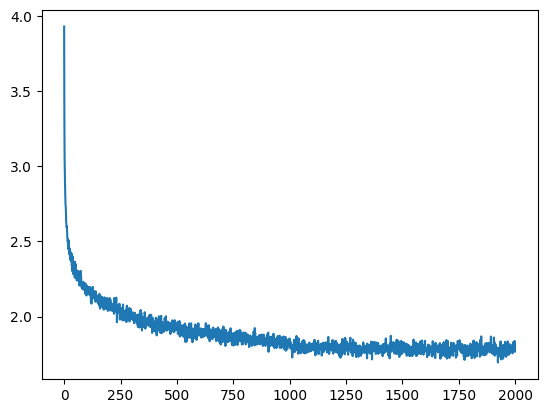

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(
    # lossi
    torch.tensor(lossi).view(-1, 100).mean(dim=1).flatten().tolist()
)

## Evaluation

In [42]:
for layer in model.layers:
    layer.training = False

In [44]:
def evaluation(X, Y):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
    return loss.item()

evaluation(Xtr, Ytr), evaluation(Xval, Yval)

(1.6969759464263916, 1.6934974193572998)

In [48]:
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        X = torch.tensor([context]) # (1, block_size)
        with torch.no_grad():
            logits = model(X)
            prob = F.softmax(logits, dim=1)
            ix = torch.multinomial(prob, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join([itos[i] for i in out]))

Oh my God! That's like ontease 'it.
Oh I can't lot not gonna does loterder the get this is of. We at's to you meor, but wascryes it.
What I do the ins. well yours.
I may a secfirthe'd that's not gonna know......I'd Bo to Stein.
Oh homall bigbit?
In tish.
Reastand then insiar, everying the preet?
I knay, hey, she ganss stumpreanding in out 1 be some.
This nowonow.!
Why cine ume.
